Exercise is meant for you to experiment with cython and numba to see how much efficiency can be obtained by using these two tools

In [1]:
import numpy as np
import seaborn as sb
import pandas as pd

In [2]:
class Particle:
  def __init__(self, x, y, ang_speed):
    self.x = x
    self.y = y
    self.ang_speed = ang_speed

In [18]:
def evolve_wrapper(dt, particles):
  timestep = 0.001
  nsteps = int(dt/timestep)
  r_i = np.array([[p.x, p.y] for p in particles])
  ang_speed = np.array([p.ang_speed for p in particles])
  evolve(r_i, ang_speed, timestep, nsteps)

  for i, p in enumerate(particles):
    p.x, p.y = r_i[i]

def evolve(r_i, ang_speed, timestep, nsteps):
  v_i = np.empty_like(r_i)
  for i in range(nsteps):
    norm_i = np.sqrt((r_i ** 2).sum(axis=1))
    v_i = r_i[:, [1,0]]
    v_i[:, 0] *= -1
    v_i /= norm_i[:, np.newaxis]
    d_i = timestep * ang_speed[:, np.newaxis] * v_i

    r_i += d_i

In [19]:
n_particle = 100
coord = np.random.randn(n_particle, 3)
particles = []
for i in range(0, n_particle):
  particles.append(Particle(coord[i][0], coord[i][1], coord[i][2]))

<AxesSubplot:xlabel='x', ylabel='y'>

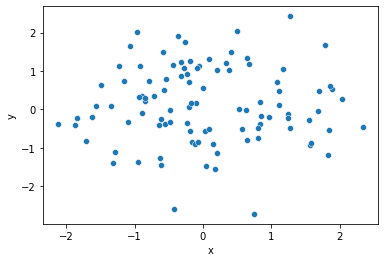

In [20]:
sb.scatterplot(x='x', y='y', data=pd.DataFrame([[p.x,p.y] for p in particles],columns = ['x', 'y']))

In [21]:
evolve_wrapper(1, particles)

<AxesSubplot:xlabel='x', ylabel='y'>

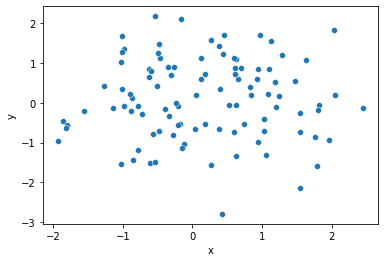

In [22]:
sb.scatterplot(x='x', y='y', data=pd.DataFrame([[p.x,p.y] for p in particles],columns = ['x', 'y']))

In [24]:
%timeit -n 10 evolve_wrapper(1, particles)

16.3 ms ± 1.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Can you rewrite the evolve method to make it faster?

In [14]:
%load_ext Cython

## Improvement 1: static typing

In [62]:
%%cython
import numpy as np
from libc.math cimport sqrt
cdef evolve_c(double[:,:] r_i, double[:] ang_speed, int timestep, int nsteps):
    v_i = np.empty_like(r_i)
    cdef int i, j
    cdef int nparticles = r_i.shape[0]
    cdef double x, y, dx, dy, vx, vy, norm
    for i in range(nsteps):
        for j in range(nparticles):
            x, y = r_i[j]
            norm = sqrt(x**2 + y**2)
            vx, vy = -1*y/norm, x/norm
            dx, dy = timestep * ang_speed[j] * vx, timestep * ang_speed[j] * vy 
            r_i[j, 0] += dx
            r_i[j, 1] += dy    
            
def evolve_wrapper_c(dt, particles):
    timestep = 1
    nsteps = int(dt/timestep)
    r_i = np.array([[p.x, p.y] for p in particles])
    ang_speed = np.array([p.ang_speed for p in particles])
    evolve_c(r_i, ang_speed, timestep, nsteps)

    for i, p in enumerate(particles):
        p.x, p.y = r_i[i]

## Improvement 1: static typing + compiler directive

In [63]:
%%cython 
import numpy as np
from libc.math cimport sqrt
cimport cython

@cython.boundscheck(False)
cdef evolve_c1(double[:,:] r_i, double[:] ang_speed, int timestep, int nsteps):
    v_i = np.empty_like(r_i)
    cdef int i, j
    cdef int nparticles = r_i.shape[0]
    cdef double x, y, dx, dy, vx, vy, norm
    for i in range(nsteps):
        for j in range(nparticles):
            x, y = r_i[j, 0], r_i[j, 1]
            norm = sqrt(x**2 + y**2)
            with cython.cdivision(True):
                vx, vy = -1*y/norm, x/norm
            dx, dy = timestep * ang_speed[j] * vx, timestep * ang_speed[j] * vy 
            r_i[j, 0] += dx
            r_i[j, 1] += dy    
            
def evolve_wrapper_c1(dt, particles):
    timestep = 1
    nsteps = int(dt/timestep)
    r_i = np.array([[p.x, p.y] for p in particles])
    ang_speed = np.array([p.ang_speed for p in particles])
    evolve_c1(r_i, ang_speed, timestep, nsteps)

    for i, p in enumerate(particles):
        p.x, p.y = r_i[i]

## Result

In [64]:
%timeit -n 10 evolve_wrapper(1, particles)
%timeit -n 10 evolve_wrapper_c(1, particles)
%timeit -n 10 evolve_wrapper_c1(1, particles)


16.1 ms ± 458 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
216 µs ± 5.51 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
125 µs ± 8.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
